In [23]:
# imports

import torch
from torchvision import datasets, transforms, models
from pathlib import Path
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.auto import tqdm
import random
import matplotlib.pyplot as plt
global device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
def setup(batch_size):
  train_transofrm = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.TrivialAugmentWide(num_magnitude_bins=15),
  transforms.ToTensor()
  ])
  test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
  ])
  data_path = Path("data/")
  image_path = data_path / "GI"

  # Setup train and testing paths
  train_dir = image_path / "train"
  test_dir = image_path / "test"

  train_dir, test_dir

  # Loading data using ImageFolder
  train_dataset = datasets.ImageFolder(train_dir, transform=train_transofrm)
  test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

  train_dataloader = DataLoader(train_dataset,
                                batch_size=batch_size,
                                shuffle=True)

  test_dataloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                shuffle=False)
  
  dict_params = {
  "num_classes": 4,
  }
  GI_model = models.densenet121(progress=True, **dict_params)
  class_names = train_dataset.classes
  return train_dataloader, test_dataloader, GI_model, class_names, train_dir, test_dir


In [25]:

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    model.eval() 
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
    
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [26]:
def create_model_load_data(model, path):
  model.load_state_dict(torch.load(path))
  return model

def save_model(model, path, name):
  torch.save(model.state_dict(), path / name)

In [27]:
def plot_predictions(model: torch.nn.Module, 
                    dataloader: torch.utils.data.DataLoader,
                    class_names: list,
                    x: int = 2,
                    y: int = 2):
    model.eval()

    images = []
    true_labels = []

    for i in range(x * y):
        randindex = random.randint(0, len(dataloader.dataset)-1)
        img, label = dataloader.dataset[randindex]
        images.append(img)
        true_labels.append(label)

    with torch.inference_mode():
        images = torch.stack(images).to(device)
        pred_logits = model(images)
        pred_labels = pred_logits.argmax(dim=1)

    fig, ax = plt.subplots(x, y, figsize=(20, 20))

    for i in range(x):
        for j in range(y):
            index = i * y + j
            ax[i, j].imshow(images[index].permute(1, 2, 0).cpu())
            ax[i, j].set_title(f"Tr: {class_names[true_labels[index]]} P: {class_names[pred_labels[index]]}", color=("green" if true_labels[index] == pred_labels[index] else "red"))
            ax[i, j].axis("off")

    plt.show()

def predict_image(model, img, class_names):
    """
    Predict the class of an image and displays the image, with title as the predicted class
    also prints out the probability of each class
    """
    transformimg = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    model.eval()
    with torch.inference_mode():
        img = transformimg(img).to(device)
        img = img.to(device)
        pred_logits = model(img.unsqueeze(0))
        pred_label = pred_logits.argmax(dim=1)
        pred_prob = torch.softmax(pred_logits, dim=1)[0][pred_label].item()
        plt.imshow(img.permute(1, 2, 0).cpu())
        plt.title(f"Predicted: {class_names[pred_label.item()]}")
        plt.axis("off")
        plt.show()

        for class_name, prob in zip(class_names, torch.softmax(pred_logits, dim=1)[0]):
            print(f"{class_name}: {prob:.4f}")

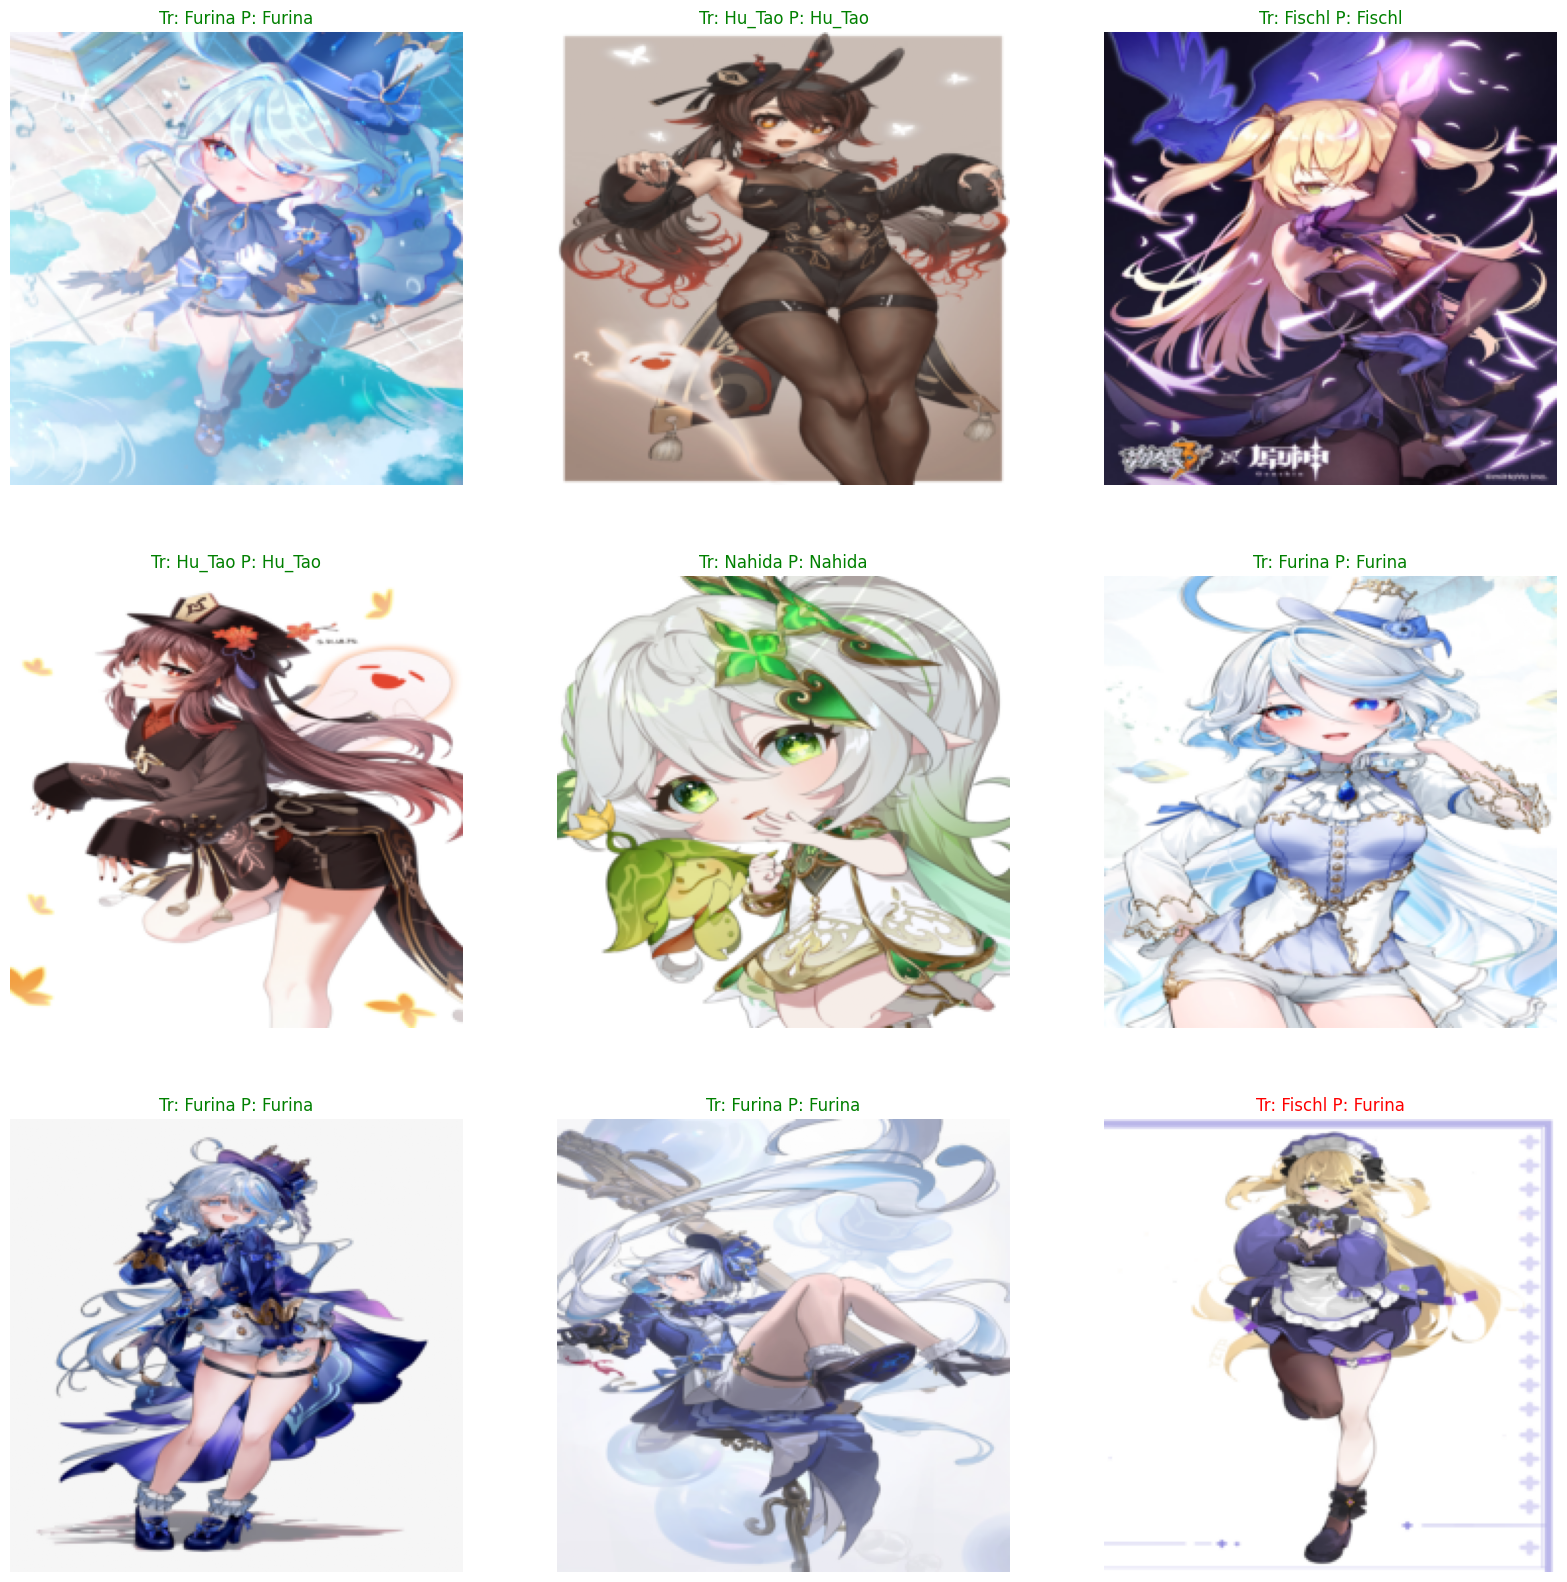

In [28]:
train_dataloader, test_dataloader, GI_model, class_names, train_dir, test_dir = setup(32)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_path = Path("models") / "GI_model_400_100.pth"
GI_model = create_model_load_data(GI_model, model_path)

plot_predictions(GI_model, test_dataloader, class_names, 3, 3)

In [29]:
# train(GI_model, train_dataloader, test_dataloader, torch.optim.Adam(GI_model.parameters(), lr=0.0001), epochs=5)

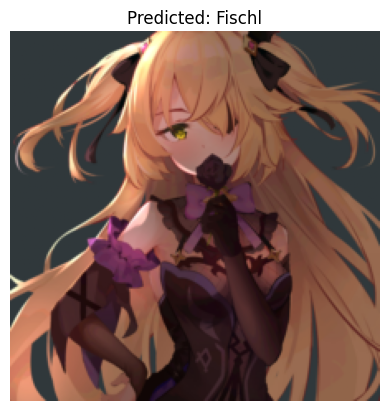

Fischl: 0.9575
Furina: 0.0089
Hu_Tao: 0.0154
Nahida: 0.0182


In [34]:
import os
from PIL import Image
os.listdir("data/GI")
n = len(os.listdir("data/GI/test/Fischl"))
predict_image(GI_model, Image.open("data/GI/test/Fischl/72.jpg"), class_names)
# for i in range(n):
#   #check if image exists
#   if not os.path.exists(f"data/GI/test/Furina/{i}.jpg") and i != 2:
#     continue
#   img = Image.open(f"data/GI/test/Furina/{i}.jpg")
#   predict_image(GI_model, img, class_names)